In [1]:
from importlib import reload

In [2]:
import numpy as np

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.io import fits
from astropy.modeling import models, fitting

In [3]:
from photutils import psf

In [4]:
%matplotlib inline
from matplotlib import rcParams
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
rcParams['image.cmap'] = 'viridis'
rcParams['image.aspect'] = 1  # to get "real" images
rcParams['figure.figsize'] = (15,10)

# First make a fake image with trivial gaussian PSFs 

In [5]:
gmod = models.Gaussian2D(x_stddev=2.5, y_stddev=2.5)

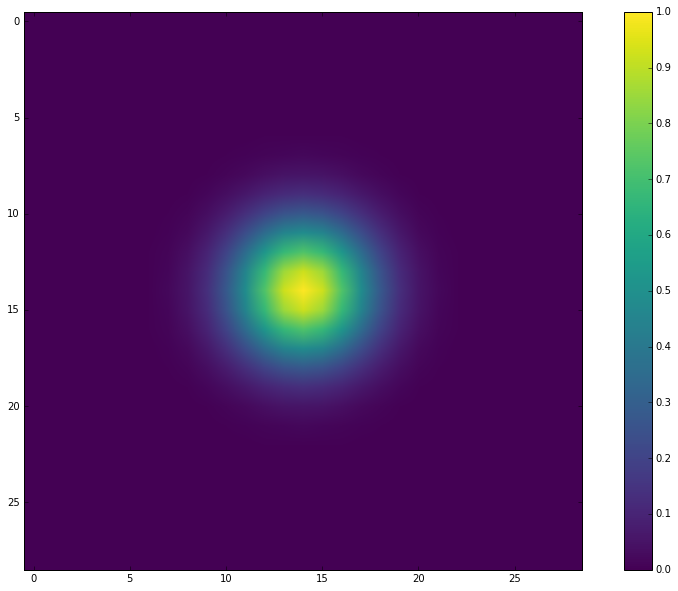

In [6]:
#uses bounding box
plt.imshow(gmod.render(), vmin=0, vmax=1)
plt.colorbar()

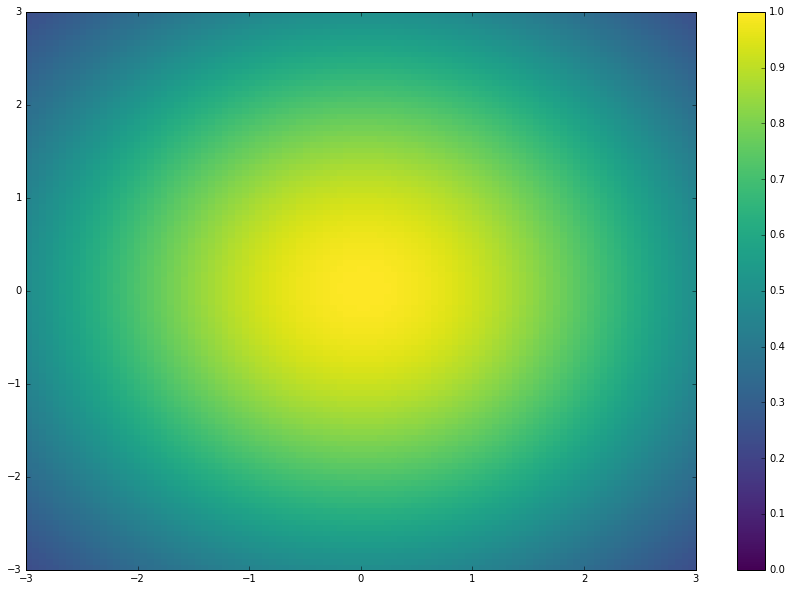

In [7]:
gmod2 = gmod.copy()
gmod2.bounding_box = None
coo = np.mgrid[-3:3:100j, -3:3:100j]

plt.gca().aspect = 1
plt.pcolor(*coo,gmod2.render(coords=coo), vmin=0, vmax=1)
plt.colorbar()

### now create an image that's just got a few PSF stars

In [8]:
nstars = 15
poisson_scale = 15
bkg = 1
flux_scale = 2500


im = np.ones((512,512))*bkg
imi = im.copy()

np.random.seed(123456789)

xs, ys = np.random.rand(2, nstars)*512
fluxes = (np.random.rand(nstars)+.5)*flux_scale

0.133333333333 5.96330427153 7.06666666667


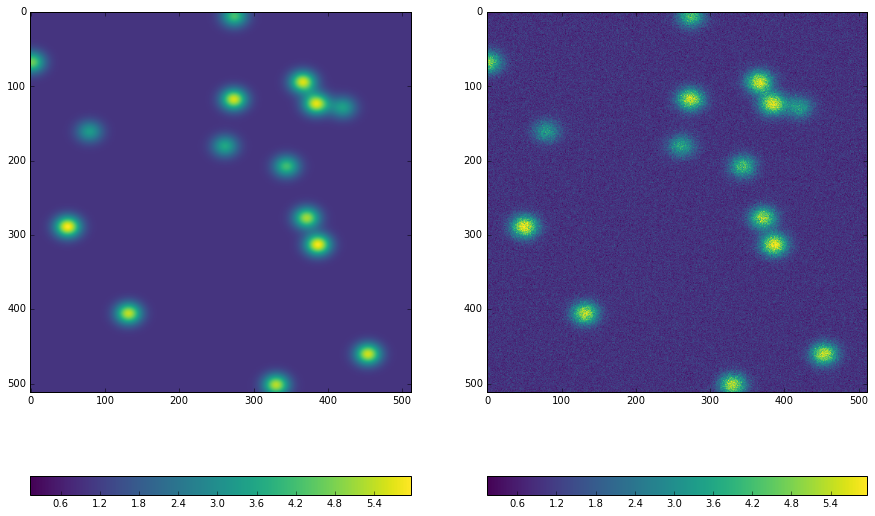

In [9]:
gmod_star = models.Gaussian2D(x_stddev=12, y_stddev=10)
round_sigma = (gmod_star.x_stddev*gmod_star.y_stddev)**0.5


intab = Table(names=['flux_0', 'x_0', 'y_0'], data=[fluxes, xs, ys])

for row in intab:
    del gmod_star.bounding_box  # resets the bounding box to the default
    gmod_star.x_mean = row['x_0']
    gmod_star.y_mean = row['y_0']
    gmod_star.amplitude = row['flux_0']/(2*np.pi*gmod_star.x_stddev*gmod_star.y_stddev)
    gmod_star.render(im)
    
pim = np.random.poisson(poisson_scale*im)/poisson_scale

plt.subplot(1,2,1)
plt.imshow(im, vmin=np.min(pim), vmax=np.max(im))
plt.colorbar(orientation='horizontal')

plt.subplot(1,2,2)
plt.imshow(pim, vmin=np.min(pim), vmax=np.max(im))
plt.colorbar(orientation='horizontal')

print(np.min(pim), np.max(im), np.max(pim))

0.133333333333 5.96330427153 7.73333333333


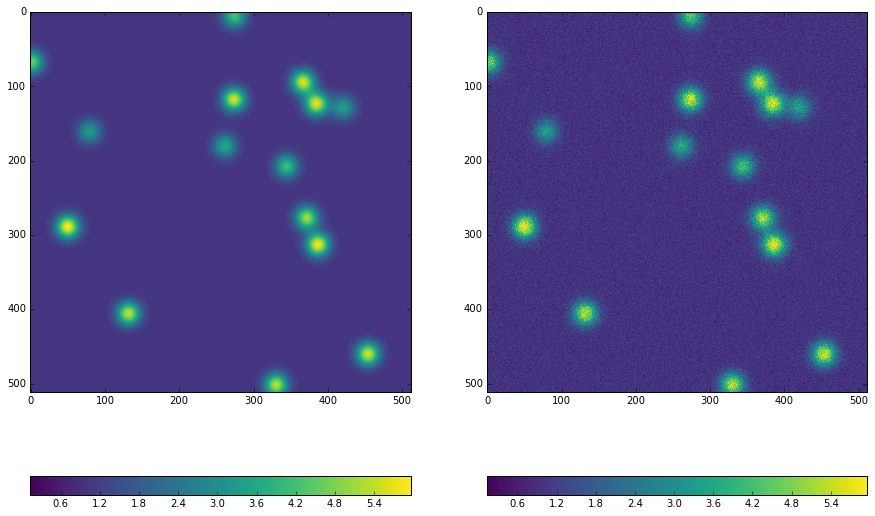

In [10]:
gmodi_star = psf.IntegratedGaussianPSF(sigma=round_sigma)

intab = Table(names=['flux_0', 'x_0', 'y_0'], data=[fluxes, xs, ys])

for row in intab:
    del gmodi_star.bounding_box  # resets the bounding box to the default
    gmodi_star.x_0 = row['x_0']
    gmodi_star.y_0 = row['y_0']
    gmodi_star.flux = row['flux_0']
    gmodi_star.render(imi)
    
pimi = np.random.poisson(poisson_scale*imi)/poisson_scale

plt.subplot(1,2,1)
plt.imshow(imi, vmin=np.min(pimi), vmax=np.max(imi))
plt.colorbar(orientation='horizontal')

plt.subplot(1,2,2)
plt.imshow(pimi, vmin=np.min(pimi), vmax=np.max(imi))
plt.colorbar(orientation='horizontal')

print(np.min(pimi), np.max(im), np.max(pimi))

In [11]:
def residuals_psf_sub_table(outtab, title=None):
    plt.subplot(3,1,1)
    if title is not None:
        plt.title(title)
    plt.scatter(np.arange(len(outtab))+1, (outtab['flux_fit']-outtab['flux_0'])*100./outtab['flux_0'])
    plt.axhline(0, ls='--', c='k')
    plt.ylabel('fluxperc')
    plt.xlim(0.5, len(outtab)+.5)

    plt.subplot(3,1,2)
    plt.scatter(np.arange(len(outtab))+1, outtab['x_fit']-outtab['x_0'])
    plt.axhline(0, ls='--', c='k')
    plt.ylabel('dx')
    plt.xlim(0.5, len(outtab)+.5)

    plt.subplot(3,1,3)
    plt.scatter(np.arange(len(outtab))+1, outtab['y_fit']-outtab['y_0'])
    plt.axhline(0, ls='--', c='k')
    plt.ylabel('dy')
    plt.xlim(0.5, len(outtab)+.5)
    
    plt.tight_layout()

In [12]:
# note that this assumes the underlying image is the same as the above
def compare_psf_sub(subim, pim, im, kw1s={}, kw2s={}, kw3s={}, kw4s={}):
    subps = (2, 2)
    cborient = 'vertical'
    
    plt.subplot(*subps,1)
    plt.imshow(pim, **kw1s)
    plt.colorbar(orientation=cborient)
    plt.title('Base image')

    plt.subplot(*subps,2)
    plt.imshow(subim, **kw2s)
    plt.colorbar(orientation=cborient)
    plt.title('PSF subtracted image')
    print("Subtracted image bkg-sub mean:", np.mean(subim-bkg), 'and SD:', np.std(subim-bkg))

    plt.subplot(*subps,3)
    plt.imshow(im, **kw3s)
    plt.colorbar(orientation=cborient)
    plt.title('Real noise-free images')

    plt.subplot(*subps,4)
    plt.imshow(pim-subim, **kw4s)
    plt.colorbar(orientation=cborient)
    plt.title('PSF images')

# Integrated gaussian

In [13]:
psf_guess = psf.IntegratedGaussianPSF(flux=1, sigma=round_sigma)
psf_guess.flux.fixed = psf_guess.x_0.fixed = psf_guess.y_0.fixed = False
psf_guess.x_0.sigma = True

Subtracted image bkg-sub mean: 3.47572159333e-06 and SD: 0.282941814374


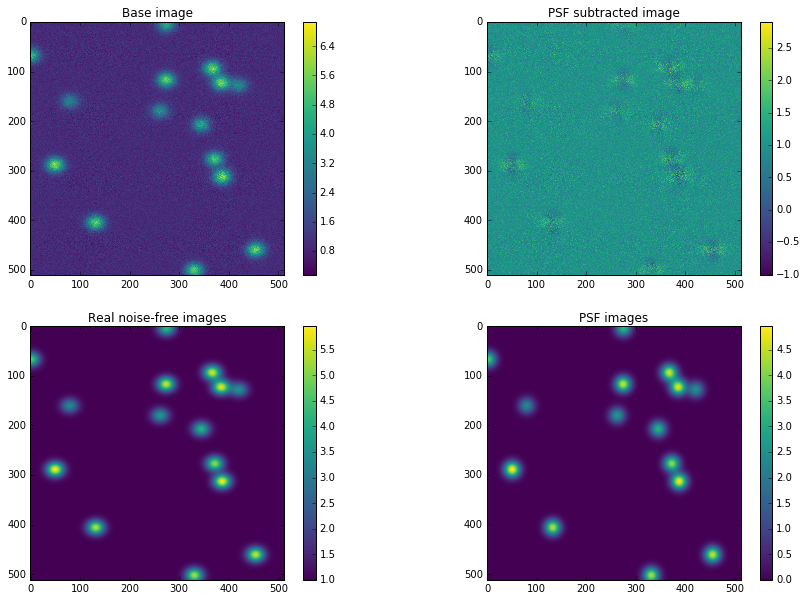

In [14]:
# this should be near-perfect psf-subtraction
subim = psf.subtract_psf(pim, psf_guess, (xs, ys, fluxes))
compare_psf_sub(subim, pim, im)

Subtracted image bkg-sub mean: -0.000252617621506 and SD: 0.277364989895


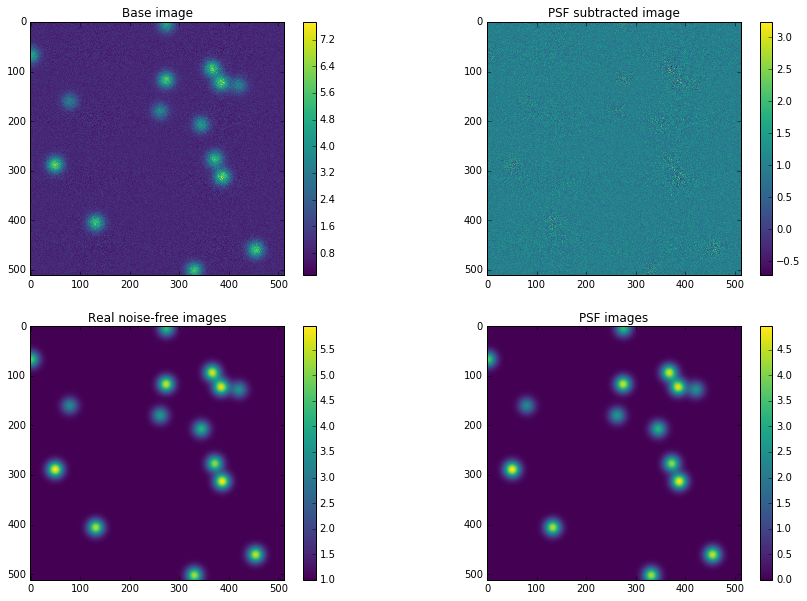

In [15]:
# Again, but for the initially integrated-pixel PSF
subimi = psf.subtract_psf(pimi, psf_guess, (xs, ys, fluxes))
compare_psf_sub(subimi, pimi, imi)

In [16]:
# fitting region used by all the below 
fitshape = (8,8)

## First try with perfect input coordinates and a fixed-shape cut region

In [17]:
outtab = psf.psf_photometry(pim - bkg, intab, psf_guess, fitshape)
outtab.show_in_notebook()

In [18]:
# with integrated psf
outtabi = psf.psf_photometry(pimi - bkg, intab, psf_guess, fitshape)
outtabi.show_in_notebook()

Subtracted image bkg-sub mean: -0.00128146504659 and SD: 0.287389397031


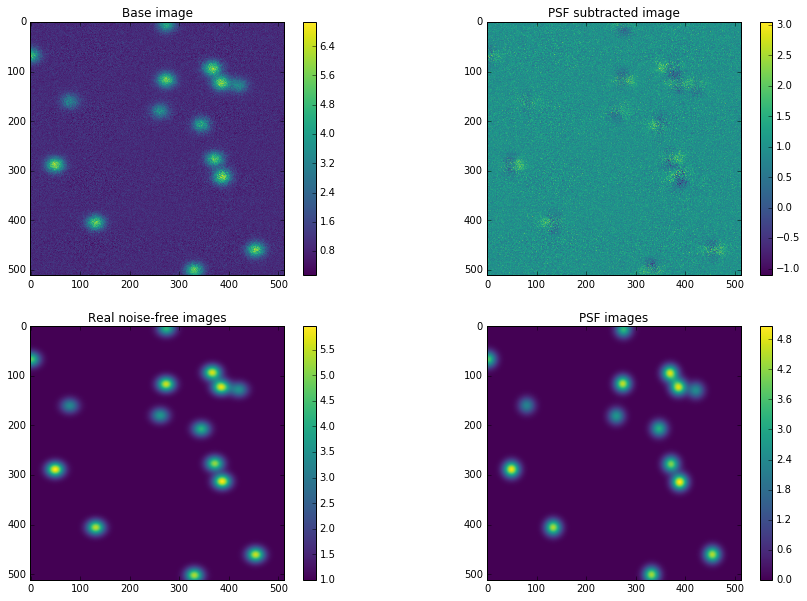

In [19]:
subim = psf.subtract_psf(pim, psf_guess, outtab)
compare_psf_sub(subim, pim, im)

Subtracted image bkg-sub mean: -0.00330236054917 and SD: 0.284415903261


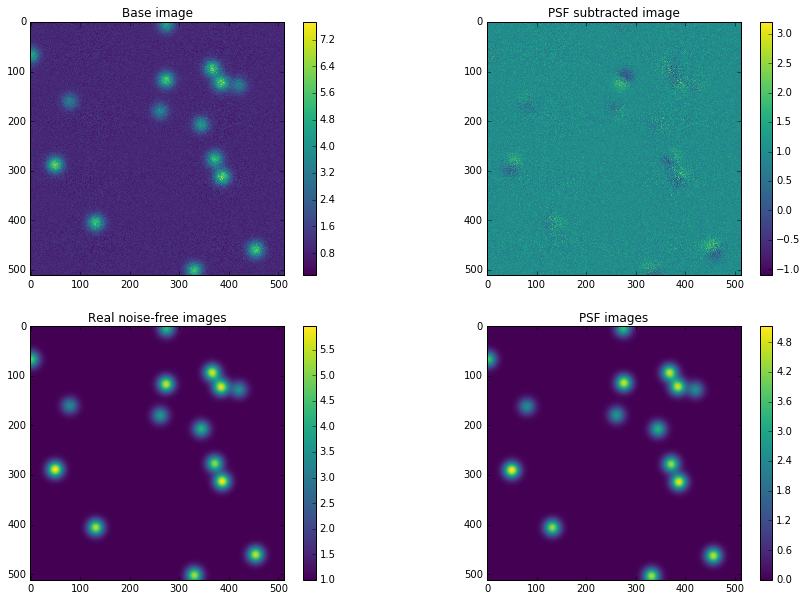

In [20]:
subimi = psf.subtract_psf(pimi, psf_guess, outtabi)
compare_psf_sub(subimi, pimi, imi)

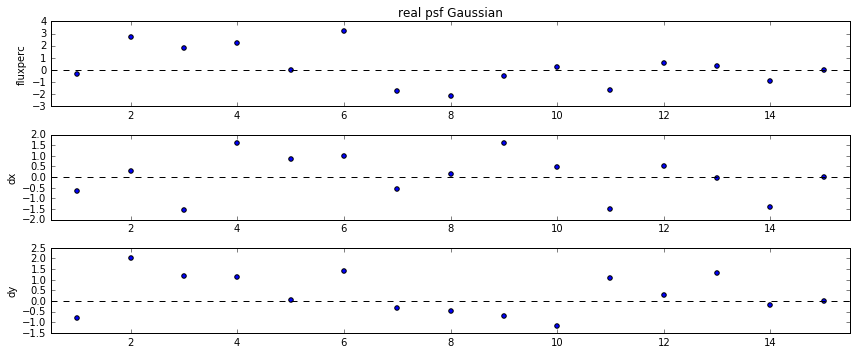

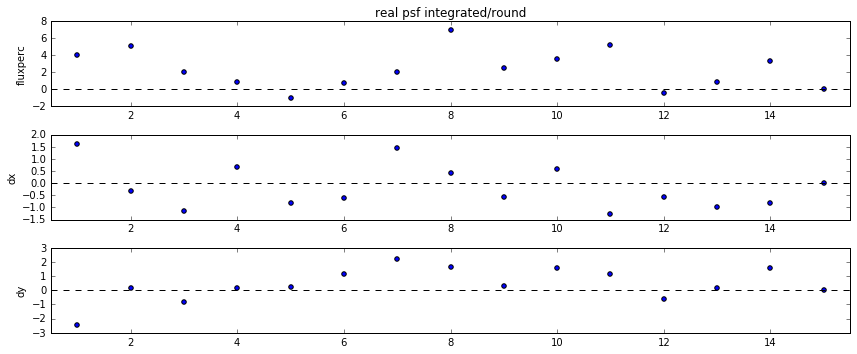

In [21]:
plt.figure(figsize=(12, 5))
residuals_psf_sub_table(outtab, title='real psf Gaussian')

plt.figure(figsize=(12, 5))
residuals_psf_sub_table(outtabi, title='real psf integrated/round')

### Now try perfect input but *no* pre-defined flux

In [22]:
intab2 = intab['x_0', 'y_0']

In [23]:
outtab = psf.psf_photometry(pim - bkg, intab2, psf_guess, fitshape, store_fit_info=True)
outtab['flux_0'] = intab['flux_0']
outtab.show_in_notebook()

Subtracted image bkg-sub mean: 0.153311074776 and SD: 0.610920067055


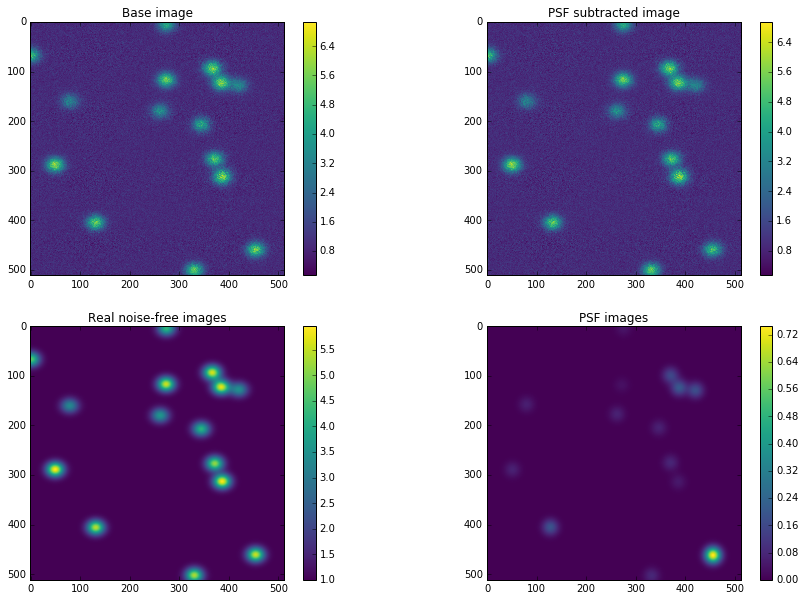

In [24]:
subim = psf.subtract_psf(pim, psf_guess, outtab)
compare_psf_sub(subim, pim, im)

In [25]:
outtabi = psf.psf_photometry(pimi - bkg, intab2, psf_guess, fitshape, store_fit_info=True)
outtabi['flux_0'] = intab['flux_0']
outtabi.show_in_notebook()

Subtracted image bkg-sub mean: 0.153054981433 and SD: 0.610832202027


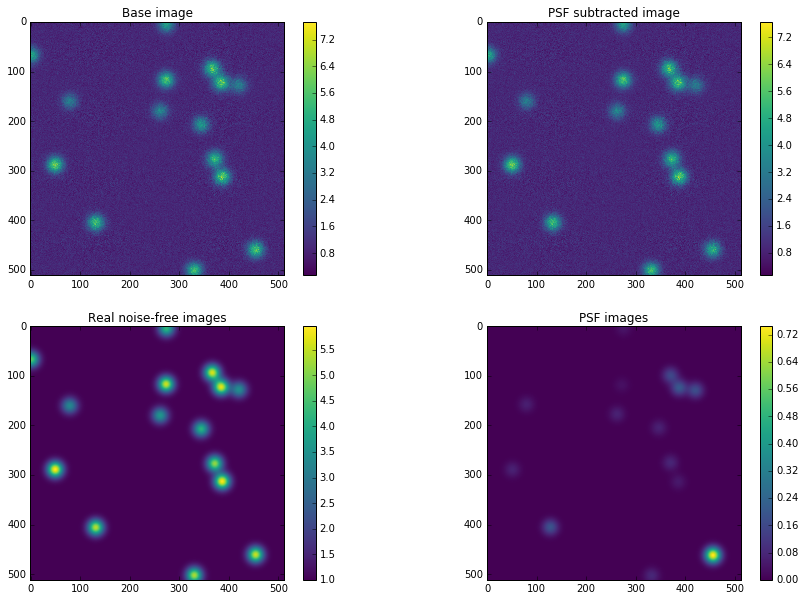

In [26]:
subimi = psf.subtract_psf(pimi, psf_guess, outtab)
compare_psf_sub(subimi, pimi, imi)

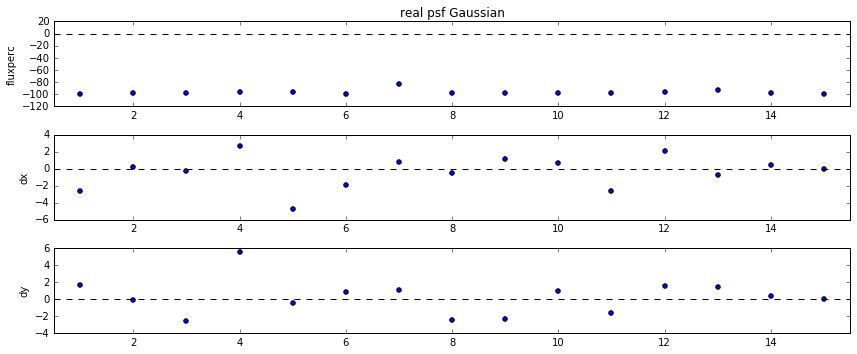

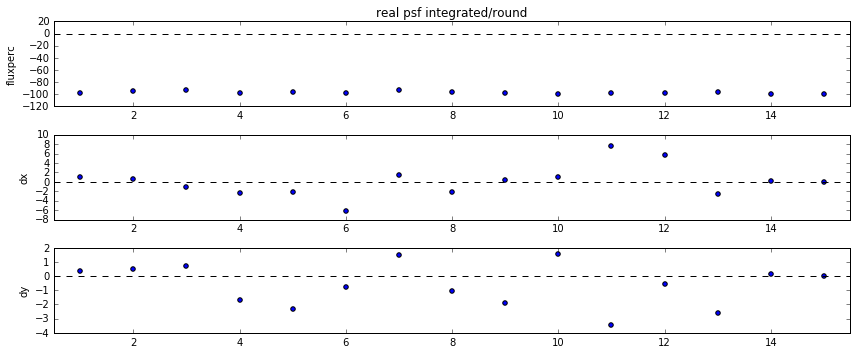

In [27]:
plt.figure(figsize=(12, 5))
residuals_psf_sub_table(outtab, title='real psf Gaussian')

plt.figure(figsize=(12, 5))
residuals_psf_sub_table(outtabi, title='real psf integrated/round')

### Lets say we have a star-finder that's good but not perfect at the ~tenth of a pixel level

In [28]:
x_finder = xs + np.random.randn(*xs.shape)*.1
y_finder = ys + np.random.randn(*ys.shape)*.1
finder_flux = fluxes + np.random.randn(*fluxes.shape)*fluxes/25

# percent error in the flux guesses
(finder_flux-fluxes)*100/fluxes

array([-3.70535738,  0.77652044,  1.25381531, -5.60526695, -4.74776774,
        1.78944808,  1.59491915,  2.17871517,  2.82077712,  1.402209  ,
       -2.06651896, -1.22882895, -2.31842863, -2.45773155, -1.5983728 ])

In [29]:
intab3 = Table(names=['x_0', 'y_0', 'flux_0'], data=[x_finder, y_finder, finder_flux])

In [30]:
outtab = psf.psf_photometry(pim - bkg, intab3, psf_guess, fitshape, store_fit_info=True)
outtab['flux_input'] = intab3['flux_0']
outtab['flux_0'] = intab['flux_0']
outtab.show_in_notebook()

Subtracted image bkg-sub mean: -0.000909923048735 and SD: 0.286873786846


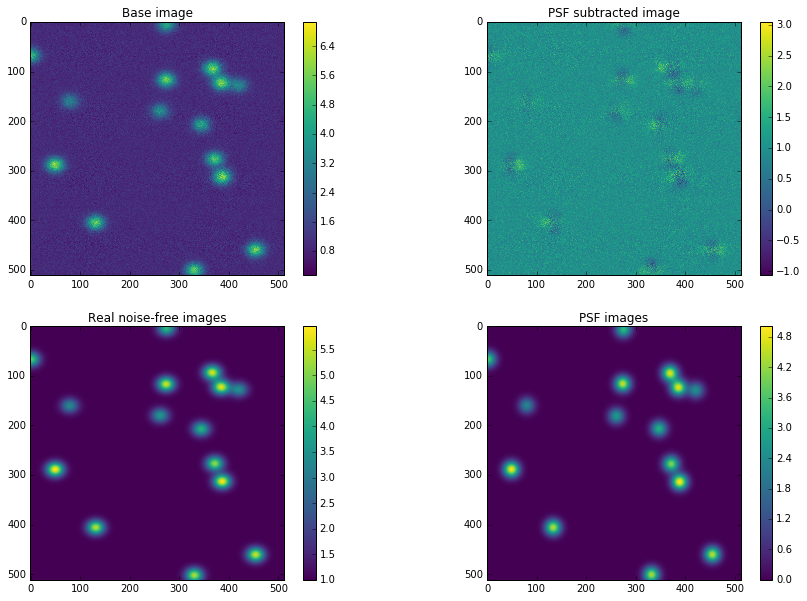

In [31]:
subim = psf.subtract_psf(pim, psf_guess, outtab)
compare_psf_sub(subim, pim, im)

In [32]:
outtabi = psf.psf_photometry(pimi - bkg, intab3, psf_guess, fitshape, store_fit_info=True)
outtabi['flux_input'] = intab3['flux_0']
outtabi['flux_0'] = intab['flux_0']
outtabi.show_in_notebook()

Subtracted image bkg-sub mean: -0.00116601639183 and SD: 0.281594075282


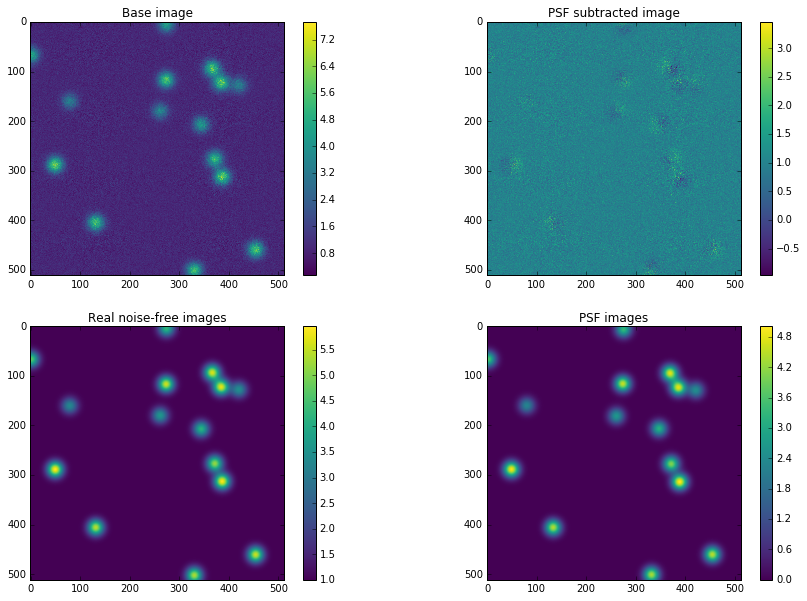

In [33]:
subimi = psf.subtract_psf(pimi, psf_guess, outtab)
compare_psf_sub(subimi, pimi, imi)

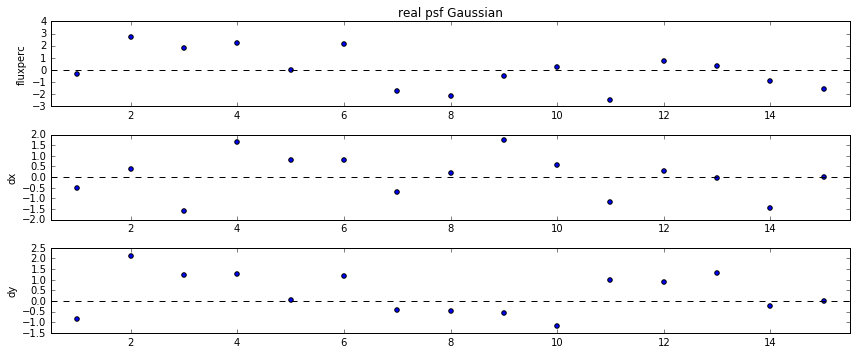

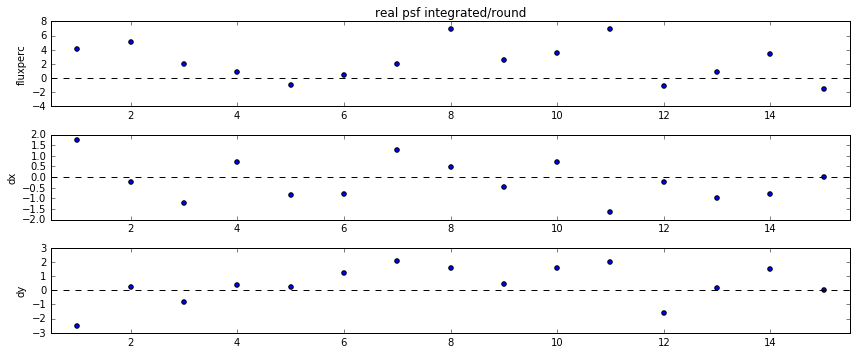

In [34]:
plt.figure(figsize=(12, 5))
residuals_psf_sub_table(outtab, title='real psf Gaussian')

plt.figure(figsize=(12, 5))
residuals_psf_sub_table(outtabi, title='real psf integrated/round')